# Model Selection Method

**Outline**
* [Introduction](#introduction)
* [Validation Set](#validation)
* Cross Validation
    * [Leave one out Cross Validation (LOOCV)](#loocv)
    * [K-fold cross validation](#kcv)
* [Grid Search](#gridsearch)
* [Out of Bag Estimate for Bagging](#oob)

---

## <a id="introduction"> Introduction </a>

When we finish building a model, if we don't have any testing data, how do we know our model is overfitting or underfitting? Actually, if we use all the data to train our model, we don't know whether if our model is overfitting or underfitting. Let's firstly assume we have built a model and have a test data to test it, if the test MSE is much higher than our train MSE, then our model is said to be overfitted.

Cross validation is a way to prevent it from happening. Before our model is fitting using the test data to get the test MSE, we manually group our train data into k fold and calculate the MSE using the kth fold each time and have a final estimate of the test MSE by averaging all the MSE of the k fold. 

The main idea of all the model selection method that we are going to introduce is to obtain an estimate of the test set MSE. When we build up a model, how can we know which model is better than another? When we don't have a test dataset available, we might imagine simply selecting the one with the lowest training MSE. However, it is not true. When a given method yields a small training MSE but a large test MSE, we are said to be overfitting the data. 

Therefore, we don't want to use training MSE to select our model. What we want is a metrics that can be an estimate of the test MSE. If we believe that estimate is correct, then the lower the estimate is, the better our model should be when we perform the model using test data later on. When doing model selection, we can imagine a plot with flexibility in x-axis and MSE in y. Each model has its level of flexibility. The more complex the model is, the higher flexibility the model is. If we reduce the flexibility of our model and result in a lower estimate test MSE, then the original model should have already been overfitted. 

When we compare the estimate test MSE of two models, A and B. A is more complex than B. If A has a lower estimate test MSE, then the next thing we can do is probably increase the flexibility of our model even more; if B has a lower CV score than A, then we might want to try to lower the flexibility of B and see if the estimate test MSE can be even lower.

Also, we know that ```Expected test MSE = Variance of the model + Bias of the model + irreducible error```. The relative rate of change of first two quantities determines whether the test MSE increases or decreases. As we increase hte flexibility of a model, the bias tend to initially decrease faster than the variance increases. Consequently, the expected test MSE declines. However, at some point increaseing flexibility has little impact on the bias but starts to significantly increase the variance. When this happens the test MSE increases.

Some of the approaches are described below.


**Some Note:**
* Overfitting refers specifically to the case in which a less flexible model would have yieled a smaller test MSE. 
* We refer to test data as the set of observations that were not used to train the model. 

To compare different approach to obtain an estimate of test MSE, we are going to use the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality). You can download the data from this [link](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). The goal is to model wine quality as a numeric value based on the features we have in the dataset.

In [114]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import cross_validation
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [5]:
wine=pd.read_csv('_data/winequality-red.csv', sep=';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
# train/test split the features and response column
X = wine.drop('quality', axis = 1).values
y = wine['quality'].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 7)

---

### <a id="validation"> Validation Set </a>

**Idea:**
separate the data into 2 parts, training and validation set. Fit model using training set and calculate the MSE using validation set.

**Drawback:**
* The validation estimate of the test error can be highly variable
* Since statistical method tends to perform worse when trained on fewer observations. Calculating the estimate MSE using validation set can overestimate the test error. In other words, it is not the model's fault, it is because we use fewer data to fit the model that result in a worse estimate of the test MSE.

### <a id="kcv"> K-fold cross validation </a>

**Pros:**
* Computational cheaper than LOOCV.
* Since we use more data to train the model, the variance will be lower than randomly using validation set for k times.
* Set aside the computational issue, k-fold often gives more accurate estimates of the test error rate than does LOOCV.

How is K-fold better than LOOCV? Bias-Variance tradeoff... Page 183.

When we fit a boosting model, the higher n_estimator, the higher flexibility for the model is. Therefore, we might want to plot out n_estimators as x, and the cross-validation score as y to see which n_estimator has the lowest estimate test MSE. Therefore, in the following example, we fit a gbm model using different number of iterations, and check the change in CV score in each iteration

In [105]:
def plot_train_test_error_kfold(X_train, X_test, y_train, y_test):
    """
    Compare the difference between training and testing error using MSE/R2 by adjusting number of tree built for GBRT.
    Here we use K-fold Cross Validation to obtain the estimate of our test MSE.
    """
    train_mse = list()
    test_mse = list()
    cv_mse = list()
    train_r2 = list()
    test_r2 = list()
    cv_r2 = list()
    kfold=10
    param_name = 'n_estimators'
    options = np.arange(1, 100)
    
    for n in options:
        gbm = GradientBoostingRegressor(n_estimators=n)
        gbm.fit(X_train, y_train)

        y_train_predict = gbm.predict(X_train)    
        train_mse.append(mean_squared_error(y_train, y_train_predict))

        cv_mse.append(abs(cross_validation.cross_val_score(gbm, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold).mean()))

        y_test_predict = gbm.predict(X_test)    
        test_mse.append(mean_squared_error(y_test, y_test_predict))

        train_r2.append(gbm.score(X_train, y_train))
        test_r2.append(gbm.score(X_test, y_test))

        cv_r2.append(model_selection.cross_val_score(gbm, X_train, y_train, cv=kfold).mean())


    mean_mse_scores = [train_mse, test_mse, cv_mse]
    mse_labels = ['train MSE', 'test MSE', 'cv MSE']       
    i_mse_optim = np.argmin(test_mse)
    options_mse_optim = options[i_mse_optim]

    mean_r2_scores = [train_r2, test_r2, cv_r2]
    r2_labels = ["train R^2","test R^2","cv R^2"]
    i_r2_optim = np.argmax(test_r2)
    options_r2_optim = options[i_r2_optim]
    
    # plot with y axis using MSE
    for score, label in zip(mean_mse_scores, mse_labels):
        plt.plot(options, score, label = label)

    plt.vlines(options_mse_optim, plt.ylim()[0], np.min(test_mse), color='k',
           linewidth=3, label='Optimum on test')    
    plt.legend()
    plt.ylabel('MSE')
    plt.xlabel(param_name)
    plt.show()
    
    # plot with y axis using R^2
    for score, label in zip(mean_r2_scores, r2_labels):
        plt.plot(options, score, label = label)

    plt.vlines(options_r2_optim, plt.ylim()[0], np.max(test_r2), color='k',
           linewidth=3, label='Optimum on test')   
    plt.legend()
    plt.ylabel('R^2')
    plt.xlabel(param_name)
    plt.show()

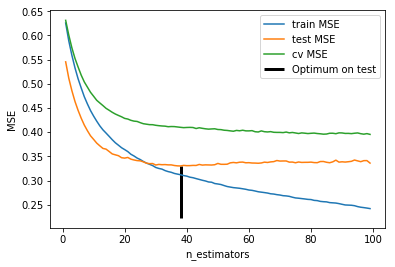

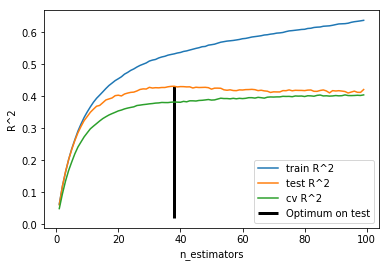

In [106]:
plot_train_test_error_kfold(X_train, X_test, y_train, y_test)

From the above plot, we see that train MSE is continuously decreasing while test test MSE slightly goes up when the number of estimator goes up. Meaning that our model is overfitted after n_estimators over some value around 40. Also, we see that the CV score aligns pretty well with our actual test MSE. Before we use test data to test the performance of our model, we can actually rely on CV score to determine which model we should use in order to have the lowest test MSE. 

## <a id="loocv"> Leave one out Cross Validation (LOOCV) </a>

**Summary:** LOOCV is a special case of k-fold CV in which k is set to equal n.

**Pros:**
* There is no randomness in the training/ validation set splits. Therefore the estimate is not variable.

**Cons:**
* Expensive to implement, since the model has to be fit n times. If the number of observation is large or the model is slow to fit, using this method can be very time consuming.

To perform LOOCV, we just need to set the number of fold into the number of observations we have in our training data. It actually take a long time to run. We'll skip the execution of the following code.

In [89]:
def plot_train_test_error_loocv(X_train, X_test, y_train, y_test):
    """
    Compare the difference between training and testing error using MSE/R2 by adjusting number of tree built for GBRT.
    Here we use leave one out Cross Validation to obtain the estimate of our test MSE.
    """
    train_mse = list()
    test_mse = list()
    cv_mse = list()
    train_r2 = list()
    test_r2 = list()
    cv_r2 = list()
    kfold=10
    param_name = 'n_estimators'
    options = np.arange(1, 100)
    
    loo = cross_validation.LeaveOneOut(len(y_train))
    
    for n in options:
        gbm = GradientBoostingRegressor(n_estimators=n)
        gbm.fit(X_train, y_train)

        y_train_predict = gbm.predict(X_train)    
        train_mse.append(mean_squared_error(y_train, y_train_predict))

        cv_mse.append(abs(cross_validation.cross_val_score(gbm, X_train, y_train, scoring='neg_mean_squared_error', cv=loo).mean()))

        y_test_predict = gbm.predict(X_test)    
        test_mse.append(mean_squared_error(y_test, y_test_predict))

        train_r2.append(gbm.score(X_train, y_train))
        test_r2.append(gbm.score(X_test, y_test))

        cv_r2.append(model_selection.cross_val_score(gbm, X_train, y_train, cv=loo).mean())


    mean_mse_scores = [train_mse, test_mse, cv_mse]
    mse_labels = ['train MSE', 'test MSE', 'cv MSE']   

    mean_r2_scores = [train_r2, test_r2, cv_r2]
    r2_labels = ["train R^2","test R^2","cv R^2"]
    
    # plot with y axis using MSE
    for score, label in zip(mean_mse_scores, mse_labels):
        plt.plot(options, score, label = label)

    plt.legend()
    plt.ylabel('MSE')
    plt.xlabel(param_name)
    plt.show()
    
    # plot with y axis using R^2
    for score, label in zip(mean_r2_scores, r2_labels):
        plt.plot(options, score, label = label)

    plt.legend()
    plt.ylabel('R^2')
    plt.xlabel(param_name)
    plt.show()

## <a id="gridsearch"> Grid Search </a>

We can also use [Grid Search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from sklearn.model_selection to obtain the parameter that generate us the best cv score. We set range of the parameters that we want to search through, and the combination with the highest CV score will be recorded. Below is an example of it:

Best hyperparameters: {'n_estimators': 98}


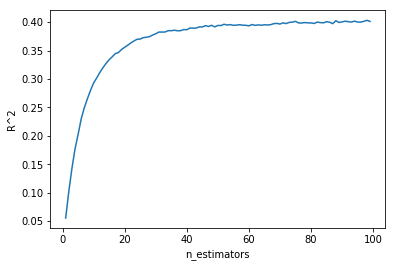

In [96]:
# set parameter range for GridSearchCV
param_name = 'n_estimators'
options = np.arange(1, 100)
param_grid = {param_name: options}

gbm = GradientBoostingRegressor()
# this may take some minutes
gs_gbm = GridSearchCV(gbm, param_grid)
gs_gbm.fit(X_train, y_train)

# best hyperparameter setting
print('Best hyperparameters: %r' % gs_gbm.best_params_)

# get the mean R^2 for all the folds, in this case, 100.
gs_gbm_mean_score = gs_gbm.cv_results_['mean_test_score']

# plot out the result with x as n_estimators and y as R^2.
plt.plot(options, gs_gbm_mean_score)
plt.ylabel('R^2')
plt.xlabel(param_name)
plt.show()

Notice that Grid Search pick the number which has the highest CV score, which in this case is R^2. The n_estimator number Grid Search pick using CV score is 98, which is a lot higher than the previous n_estimators we saw using the actual test data, which is around 40. 

However, when we don't have a test data with us. Using cross validation score to pick the best n_estimators number seems to be our only choice for now.

**We can set the parameter to fit our final model using the following command.**

In [98]:
# refit model on best parameters
gbm.set_params(**gs_gbm.best_params_)
gbm.fit(X_train, y_train)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=98, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

**Predict the final result**

In [102]:
gbm.predict(X_test)[1:10]

array([ 5.56218169,  6.28635755,  5.49330293,  6.10269198,  5.65476195,
        5.46981983,  6.52166422,  5.45564734,  5.24649586])

## <a id="oob"> Out of Bag Estimate for Bagging </a>

In bagging, it turns out we can use another technique called **Out of Bag Error Estimation** to estimate the test error. Originally, if we also want to use cross validation to estimate the test error of our training data set, performing bagging on large data sets would be computationally expensive. Let's assume we want to use 10-fold cross validation and bootstrap 21 training data set when building a model. In this case, for each fold we'll need to build 21 models, i.e, we train our method on the **bth** bootstrapped training set in order to get our estimated function, denoted by $\hat{f}^b(x)$. We then get our final prediction using the average of the predictions from each model, $\hat{f}^1(x), \hat{f}^2(x), \dots \hat{f}^{21}(x)$. Therefore, totally we will need to build $21 \times 10 = 210$ models in order to get an estimation of the test error. 

It turns out that we can actually get our test error estimation for a bagged model in an intuitively way. Since we know that in bagging, essentially we fit our model on a subset of the original training data set. For illustration purpose, let's say in each subset, we randomly use 2/3 of the original data set, and we totally take 21 bootstrapped training sets. For the $i_{th}$ observation, it will be in the training set in 14 of the bootstrapped training sets. We can predict the response for the $i_{th}$ observation using each of the trees in which that observation was out ob bag (OOB). This will yield around 7 predictions for the $i_{th}$ observation. To obtain a single prediction, we can average these predicted responses for regresssion tree or can take a mojority vote for classification tree. By using **Out of Bag Error Estimation**, we will only need to build 21 models but still get a fairly good estimation of the test error. It is particularly convenient when performing bagging on large data sets. 


In [150]:
def plot_train_test_error_oob(X_train, X_test, y_train, y_test):
    """
    Compare the difference between training and testing error using MSE/R2 by adjusting number of tree built for GBRT.
    Here we use K-fold Cross Validation to obtain the estimate of our test MSE.
    """
    train_mse = list()
    test_mse = list()
    oob_mse = list()

    seed = 7
    num_trees = 100    
    param_name = 'n_estimators'
    options = np.arange(15, 100)
    
    for n in options:
        # fit random forest using different n_estimator, i.e., the number of trees that we fit each time for bagging.
        rf = RandomForestRegressor(n_estimators=n, oob_score=True, warm_start=True, random_state=seed)
        rf.fit(X_train, y_train)
        
        # get train mse
        train_mse.append(1-rf.score(X_train, y_train))
        
        # get test mse
        test_mse.append(1-rf.score(X_test, y_test))

        # get oob estimates
        oob_mse.append(1-rf.oob_score_.mean())

    mean_mse_scores = [train_mse, test_mse, oob_mse]
    mse_labels = ['train MSE', 'test MSE', 'oob MSE']       
    i_mse_optim = np.argmin(test_mse)
    options_mse_optim = options[i_mse_optim]

    
    # plot with y axis using MSE
    for score, label in zip(mean_mse_scores, mse_labels):
        plt.plot(options, score, label = label)

    plt.vlines(options_mse_optim, plt.ylim()[0], np.min(test_mse), color='k',
           linewidth=3, label='Optimum on test')    
    plt.legend()
    plt.ylabel('OOB Error Rate=1-R^2')
    plt.xlabel(param_name)
    plt.show()
    return(train_mse, test_mse, oob_mse)

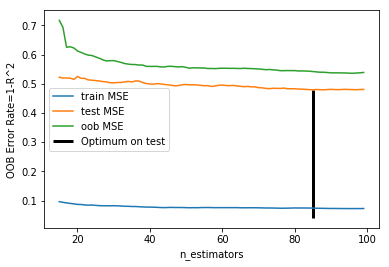

In [151]:
train_mse, test_mse, oob_mse= plot_train_test_error_oob(X_train, X_test, y_train, y_test)

From the above plot, we see that random forest is a relatively steady approach for our data. The algorithm gives us a low train MSE even with small n_estimators.

The test MSE doesn't decrease much when n_estimator goes higher. We see that like CV score, OOB error rate, which is defined by 1 - R^2, estimate our test MSE pretty well when n_estimators goes larger. We notice that when n_estimators is small, our oob error rate overestimate the test MSE. It is due to the fact that when n_estimators is small, for example, when n=2. It means we only build 2 full trees when building a random forest. Assume we have 100 observations and the subsample rate is 0.7, we predict the response for the ith observation using only 1 tree in which that observation was out ob bag (OOB). The reason for overestimate is the same as using Validation set to obtain the estimate test MSE. Since for each tree we use fewer training data to build our full tree, it is not surprised that we will have a weaker prediction. In other words, it is not the model's fault, it is because we use fewer data to fit the model that result in a worse estimate of the test MSE. 

### Reference
* [Plot train error vs test error](http://scikit-learn.org/stable/auto_examples/model_selection/plot_train_error_vs_test_error.html)
* [Sklearn: Underfitting vs. Overfitting](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)
* [Sklearn: OOB Errors for Random Forests](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)